# Resturant Food Safety Inspection Prediction Using Natual Language Processing

The goal of this notebook is to build a multinomial classification model to predict the outcome of the food safety inspection reports based on the inspectors' comments. I will use from statistical analysis and natural language processing to accomplish this. I will also present the results of the classification model and suggest ways that it could be improved through further analysis.

Data provided by the City of Chicago via https://data.cityofchicago.org/ as of early 2020.

https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5

## Summary
### 1. Objective
### 2. Data
### 3. Cleaning
### 4. Model Building
### 5. Interpretation of Results

## 1. Import Libraries / Load the Data

In [2]:
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import itertools


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import sys

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.mode.chained_assignment = None  # default='warn'


In [4]:
#load the data
df = pd.read_csv('../Food_Inspections.csv')

df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2369955,HUMBOLDT HAUS DELI & LIQUOR,HUMBOLDT HAUS DELI & LIQUOR,2192995.0,Liquor,Risk 1 (High),2956-2958 W NORTH AVE,CHICAGO,IL,60647.0,04/30/2020,Canvass Re-Inspection,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17 OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMEN'S WASHROOM. MUST PROVIDE.",41.910286,-87.701373,"(-87.70137268454522, 41.91028581429125)"
1,2369959,SUPER JALAPENO GRILL INC.,JALAPENO GRILL,2252227.0,Restaurant,Risk 1 (High),2910 W ARMITAGE AVE,CHICAGO,IL,60647.0,04/30/2020,Canvass Re-Inspection,Pass,NaN,41.917572,-87.699859,"(-87.69985903100972, 41.917572160779464)"


In [5]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205234 entries, 0 to 205233
Data columns (total 17 columns):
Inspection ID      205234 non-null int64
DBA Name           205234 non-null object
AKA Name           202763 non-null object
License #          205217 non-null float64
Facility Type      200408 non-null object
Risk               205164 non-null object
Address            205234 non-null object
City               205084 non-null object
State              205190 non-null object
Zip                205181 non-null float64
Inspection Date    205234 non-null object
Inspection Type    205233 non-null object
Results            205234 non-null object
Violations         150738 non-null object
Latitude           204546 non-null float64
Longitude          204546 non-null float64
Location           204546 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 26.6+ MB
None
       Inspection ID     License #            Zip       Latitude  \
count   2.052340e+05  2.052170e+05 

In [6]:
pd.DataFrame({'count':df.Results.value_counts(),
              'percent':df.Results.value_counts()/len(df)})

,count,percent
Pass,108721,0.529742
Fail,39640,0.193145
Pass w/ Conditions,30183,0.147066
Out of Business,17763,0.086550
No Entry,6803,0.033148
Not Ready,2052,0.009998
Business Not Located,72,0.000351


In [7]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

A couple observations. 
* There are a lot of extra unneccesary columns
* We care about 'results', and 'violations'
* \>50K N/A's in violations column
* This is a multinomial classification problem. We'll narrow the classes to pass, fail, and pass w/ conditions due to data insufficency and other limitations.


In [8]:
#Drop Unneccesary Columns
select_cols = ['Results', 'Violations']
df = df[select_cols]

#Drop classes with insufficient data
df = df[(df.Results=='Pass')|(df.Results=='Fail')|(df.Results=='Pass w/ Conditions')]

#drop N/As
df = df.dropna(subset =['Violations'], axis=0)


In [9]:
df.head(2)

,Results,Violations
0,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17 OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMEN'S WASHROOM. MUST PROVIDE."
2,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO PROCEDURE IN PLACE FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 36. THERMOMETERS PROVIDED & ACCURATE - Comments: MISSING FOOD TEMPERATURE MEASURING DEVICE. INSTD TO PROVIDE AND MAINTAIN SAME. PRIORITY FOUNDATION 7-38-005. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: MISSING TOILET TANK COVER. INSTD TO REPLACE AND MAINTAIN. TOILET HANDLE LOOSE. INSTD TO REPAIR AND MAINTAIN.


## 2. Feature Engineering
* Extract only comments from violations, drop rest of text
* map Results_Flag

In [10]:
df.iloc[0]['Violations']

"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17  OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMEN'S WASHROOM. MUST PROVIDE."

In [11]:
df.Violations = df.Violations.str.findall(r"(?:\sComments:\s.*?)?(?:[|]|$)")

#Lemmatize Violations
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df.Violations = df.Violations.str.join(' ')

#Remove Punctuation
df['Violations'] = df['Violations'].str.replace('[^\w\s]','')

#Remove non-alphanumeric
df['Violations'] = df['Violations'].str.replace('[^\D\s]','')


In [12]:
df['Results'].value_counts()

Pass                  84015
Fail                  36500
Pass w/ Conditions    29671
Name: Results, dtype: int64

In [13]:
# convert label to a binary numerical variable
df['Results_Flag'] = df.Results.map({'Pass':0,
                                     'Fail':1,
                                     'Pass w/ Conditions':2,
                                     'No Entry':3,
                                     'Not Ready':4,
                                     'Out of Business':5 })

## 3. Set X & y Variables, Train/Test Split

In [14]:
X = df.Violations
y = df.Results_Flag
print(X.shape)
print(y.shape)

(150186,)
(150186,)


In [15]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120148,)
(30038,)
(120148,)
(30038,)


## 4. Vectorize The Text

In [16]:
# instantiate the vectorizer
vect = CountVectorizer()

In [17]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [18]:
# examine the document-term matrix
X_train_dtm

<120148x89715 sparse matrix of type '<class 'numpy.int64'>'
	with 8235788 stored elements in Compressed Sparse Row format>

In [19]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<30038x89715 sparse matrix of type '<class 'numpy.int64'>'
	with 2039319 stored elements in Compressed Sparse Row format>

In [20]:
countvectorizer_matrix = vect.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

,___lbs,__through,_a,aa,aab,aade,aafound,aal,aall,aamust,...,zuchinicabbagecooked,zuchinisasparagus,zumba,zumex,zurich,ï½,ï½c,ï½f,ï½time,ï½ï½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X_train

33499                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Comments INSTRUCTED TO PROPERLY LABEL FOOD STORAGE CONTAINERSBINS IDENTIFIED WITH COMMON NAME   Comments INSTRUCTED TO TRANSFER FOOD PRODUCTS FROM AN OPEN ORIGINAL CAN CONTAINER INTO FOOD GRADE CONTAINER FOR PROPER FOOD STORAGE     Comments INSTRUCTED TO REPAIR LOOSE HANDSINK IN BAKERY PREP AREA   Comments INSTRUCTED TO RE GROUT FLOOR TILES WITH DEEP SEAMS AND CRACKED AROUND MEAT PREP AREA    Comments FOOD AND NON FOOD ITEMS MUST BE STORED  OFF THE FLOOR FOR EASY ACCESS ON CLEANING MUST PROVIDE PROPER RAISED SHELVES AND NO MILK

## 5. Build Baseline Models
* Naive Bayes Model
* Logistic Regression
* Support Vector Machine

### a) Naive Bayes Model

In [19]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [20]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 58.6 ms, sys: 9.29 ms, total: 67.9 ms
Wall time: 66.9 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [22]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.8279845528996604


In [23]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     16804
           1       0.74      0.72      0.73      7300
           2       0.65      0.77      0.71      5934

    accuracy                           0.83     30038
   macro avg       0.78      0.80      0.79     30038
weighted avg       0.84      0.83      0.83     30038



In [24]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[15012   759  1033]
 [  629  5264  1407]
 [  242  1097  4595]]


### b) Logistic Regression

In [25]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=1000)

In [26]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 10min 40s, sys: 2min 24s, total: 13min 5s
Wall time: 2min 48s


/Users/stephenstark/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
y_pred_class_train = logreg.predict(X_train_dtm)

In [28]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9239296890605233


In [29]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16804
           1       0.88      0.84      0.86      7300
           2       0.86      0.85      0.85      5934

    accuracy                           0.92     30038
   macro avg       0.90      0.89      0.90     30038
weighted avg       0.92      0.92      0.92     30038

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     67211
           1       0.96      0.94      0.95     29200
           2       0.95      0.94      0.95     23737

    accuracy                           0.97    120148
   macro avg       0.96      0.96      0.96    120148
weighted avg       0.97      0.97      0.97    120148



In [30]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16603   127    74]
 [  403  6129   768]
 [  186   727  5021]]


### c) Support Vector Machine

In [31]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [32]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

CPU times: user 12.2 s, sys: 204 ms, total: 12.4 s
Wall time: 11.7 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [34]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9185365204074839


In [35]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     16804
           1       0.88      0.83      0.85      7300
           2       0.85      0.85      0.85      5934

    accuracy                           0.92     30038
   macro avg       0.90      0.89      0.89     30038
weighted avg       0.92      0.92      0.92     30038



In [36]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16499   192   113]
 [  527  6027   746]
 [  200   669  5065]]


### 6. Improve Model Performance (for best performing model)
* Remove stopwords
* Include n-grams
* Limit min & max document frequencies



In [37]:
#default parameters for countvectorizer model
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [38]:
# remove English stop words
vect_optimized = CountVectorizer(stop_words='english',
                                 lowercase=True,
                                 ngram_range=(1,4), 
                                 min_df=0.1, 
                                 max_df=0.2)



In [39]:
countvectorizer_matrix = vect_optimized.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect_optimized.get_feature_names())
countvectorizer_matrix_df

,area comments,basement,broken,buildup,ceiling tiles,ceilings,chicago,citation,citation issued,citation issued comments,...,use,used,utensils,utensils shall,ventilation,violation comments,walk,walkin,washing,washroom
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,2,0,0,0,0,0,1,0,0,0,...,0,0,3,2,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120143,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120144,0,0,0,0,0,0,0,0,0,0,...,2,0,2,0,0,0,0,0,0,0
120145,0,0,0,0,2,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
120146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect_optimized.fit_transform(X_train)
X_test_dtm = vect_optimized.transform(X_test)


In [41]:
#Logistitc Regression
model = LogisticRegression(max_iter=500)
%time model.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

CPU times: user 15.7 s, sys: 74 ms, total: 15.8 s
Wall time: 15.8 s
0.870231040681803


/Users/stephenstark/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [42]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     16804
           1       0.80      0.71      0.75      7300
           2       0.77      0.73      0.75      5934

    accuracy                           0.87     30038
   macro avg       0.83      0.81      0.82     30038
weighted avg       0.87      0.87      0.87     30038



In [43]:
#Check for over fitting
y_pred_class_train = model.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     67211
           1       0.80      0.72      0.76     29200
           2       0.77      0.73      0.75     23737

    accuracy                           0.87    120148
   macro avg       0.83      0.81      0.82    120148
weighted avg       0.87      0.87      0.87    120148



Text(69.0, 0.5, 'Actual')

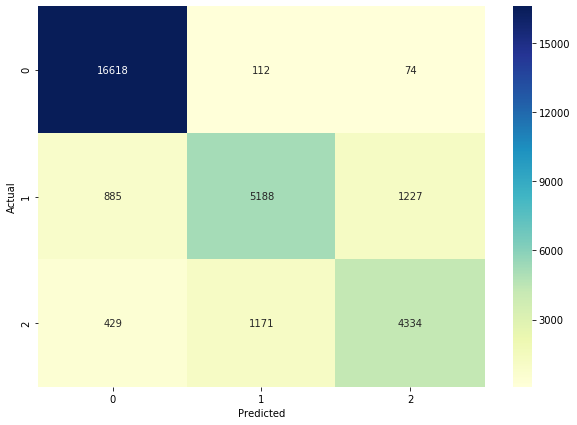

In [44]:
cnf_matrix_test = confusion_matrix (y_test, y_pred_class)

import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix_test, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### 7. Troubleshoot

In [45]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [46]:
y_pred_prob = model.predict_proba(X_test_dtm)
y_pred_class = model.predict(X_test_dtm)

In [47]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [48]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [49]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

(2853, 6)

In [50]:
pd.set_option('display.max_colwidth', 200)

In [51]:
results_review_df.head(10)

,Violations,Results_Flag,predicted,0-prob,1-prob,2-prob
10,Comments CONTINUED EVIDENCE OF INSECTS AND RODENTS ON SITE AND OUTER OPENINGS NOT PROTECTED NOTED APPROXIMATELY LIVE SMALL FLIES RESTING ON WALLS IN THE REAR STORAGE AREASIN CLOSETSUNDER THREE C...,1,1,1.631647e-01,0.455340,0.381495
12,Comments NO VALID CITY OF CHICAGO FOOD SERVICE MANAGER CERTIFICATE POSTED AND NO VALID PROOF OF ENROLLMENT AVAILABLE AT THIS TIME SERIOUS CITATION ISSUED Comments MUST SEAL SMALL OPENING ALON...,1,1,3.704746e-02,0.537681,0.425271
25,Comments NO CHEMICAL TEST KIT ON SITE AT THIS TIME OF INSPECTIONINSTRUCTED TO PROVIDE AND MAINTAIN A CHEMICAL TEST KIT FOR THE DISHWASHING COMPARTMENT SINK AND SANITIZING BUCKETS AS REQUIRED SER...,1,2,1.940786e-02,0.399485,0.581107
26,Comments OBSERVED THE FOLLOWING FOODS STORED AT IMPROPER TEMPERATURE IN PREP COOLER SEAFOOD SALAD F CRABMEAT F COOKED FISH F CREAM CHEESE F INSTRUCTED MANAGER TO DISCARD APPROXIMATELY LBS AND OF...,2,2,1.334491e-13,0.481978,0.518022
46,Comments NOTED EMPLOYEES PREPPING SANDWICHES MOVING FROM PREP TABLE TO REFRIGERATION UNIT AT THE REAR AND TO THE CASH REGISTRY WHILE CHANGING GLOVES DID NOT OBSERVE EMPLOYEES WASHING HANDS IN BET...,2,1,7.537399e-06,0.513707,0.486286
53,Comments All food establishments shall be provided with an adequate supply of hot and cold water under pressure properly connected to the city water supply NO HOT WATER PROVIDED THROUGHOUT THE P...,1,0,5.550186e-01,0.313203,0.131779
57,Comments OBSERVED POOR HYGIENIC PRACTICES BY FOOD HANDLERSOBSERVED MALE FOOD HANDLER WALKING AROUND IN LOBBY AND THEN CAME INTO PREP AREA AND STARTED COOKING AND A FEMALE FOOD HANDLER WAS TOUCHIN...,2,0,4.752916e-01,0.172990,0.351719
62,Comments OBSERVED POTENTIALLY HAZARDOUS FOODS AT IMPROPER TEMPERATURES INSIDE OF THE WALKIN COOLER OBSERVED CHEESE AT F YOGURT AT F EGGS AT F MILK AT F CANADIAN BACON AT F MANAGEMENT VOLUNTARIL...,1,2,3.825011e-09,0.430275,0.569725
66,Comments OBSERVED OVER FRUIT FLIES IN SUMP PUMP ROOM IN BASEMENT AND OVER FRUIT FLIES IN BASEMENT PREP AREA NEAR COMPARTMENT SINK MUST ELIMINATE ALL FRUIT FLY ACTIVITY AND MAINTAIN SERIOUS VIO...,1,1,3.508636e-02,0.594850,0.370064
86,Comments LEOBARDO CARDENAS HAS NO CURRENT SANITATION CERTIFICATE POSTED OR AVAILABLE AT THIS TIME OF INSPECTION ONLY HAS A REGISTRATION FORM ONLY NO RECEIPT CITATION ISSUED Comments LABEL BUL...,2,2,2.668616e-02,0.408786,0.564528


# Summary
I decided to perform a multi-class classification analysis.  I narrowed my dataset to pass, fail, or pass w/ conditions due to the sufficiency of data. It appears the logistic regression had the best performance of the three models I demonstrated above. The original logisitc regression actually performed better than the one I attempted to optimize. It had a test accuracy of 92%.  The model showed slight signs of overfitting as train accuracy was 96%. Precision and recall for test were 92% for each. Precision was 96% for class 0 (pass), 87% for class 1 (fail) and 86% for class 2 (pass w/ conditions). Furthermore we know f-1 scores are the weighted averaged of precision and recall. F1 scores of 98%, 86%, and 85%, for the same classes listed previously. The model clearly is able to accuractely identify pass recommendations but struggles a little more with fail and pass with conditions, which makes sense intuitively. the F1 scores show slightly more signs of overfitting so I would attempt to adjust that in my parameter tuning. This is out of scope for this analysis, but perhaps I would do some sort of grid search or random search to approximate better parameter values.
* **Pre-processing** For text pre-processing, I decided that we needed to remove stopwords for this analysis. They are noise and do not contribute to the signal of the prediction. I also removed all the digits as again I believe they were more of a distraction. Also, within CountVectorizer, I included parameters to lowercase all words an
* **Train/Test Split** I noticed a considerable class imbalance in the dataset between the three values. I made sure to stratify my sampling in train test split to ensure the train samples and test samples resembled the population of the dataset. Another thing I considered doing but did not as it was out of scope for this analysis was training my model on an equal split data using an under-sampling or oversampling approach. This would give the model a fair chance to fully train each class equally as opposed to seeing more data of the dominate class.
